# DeepLabCut Test Notebook for Data Visualization

The objective of this notebook is to figure out how to read, handle, and visualize DLC data so that we can "quantify" the behavior of mice and compare WT to disease models.

In [1]:
# handling data
import pandas as pd
import numpy as np
import openpyxl

# visualizing data
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("darkgrid")

# Statistics
from scipy import stats
import statsmodels.api as sm
import statsmodels.imputation.mice as smi
import scipy.cluster.hierarchy as hac
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.imputation.mice import MICEData
import matplotlib.gridspec as gridspec
import math
import random


#SHAP Value Stuff
import shap
from shap import TreeExplainer
from shap import GradientExplainer
from shap import DeepExplainer
from shap import KernelExplainer
from shap import SamplingExplainer
from shap import PartitionExplainer

#Extras
from utils import *
import math

#Time data stuff, neural network stuff?
import time
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime


#Data processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

#ML models
import xgboost as xgb
import catboost as ctb


print("Setup Complete")

Setup Complete


In [2]:
pwd


'/Users/aidanlew/DLC'

In [3]:
cd '/Users/aidanlew/Documents'

/Users/aidanlew/Documents


# Setting Up the Data

In [4]:
cage1_df=pd.read_csv('../Documents/WT_test_DLC_data/cage1_WT_social_trial.csv',
                             #skiprows=1
                             )
cage1_df.tail()

,HomeMouse_Snout_x,HomeMouse_Snout_y,HomeMouse_LeftEar_x,HomeMouse_LeftEar_y,HomeMouse_RightEar_x,HomeMouse_RightEar_y,HomeMouse_Tailbase_x,HomeMouse_Tailbase_y,UnfamiliarMouse_Snout_x,UnfamiliarMouse_Snout_y,...,UnfamiliarMouse_Tailbase_x,UnfamiliarMouse_Tailbase_y,FamiliarMouse_Snout_x,FamiliarMouse_Snout_y,FamiliarMouse_LeftEar_x,FamiliarMouse_LeftEar_y,FamiliarMouse_RightEar_x,FamiliarMouse_RightEar_y,FamiliarMouse_Tailbase_x,FamiliarMouse_Tailbase_y
27167,1342.095,700.735,1363.636,647.077,1317.101,643.423,1270.105,495.641,1395.500,314.658,...,1186.090,320.832,1349.596,753.617,1285.402,683.352,1247.582,742.086,1143.317,626.914
27168,1342.095,700.776,1363.636,651.323,1317.101,652.958,1270.178,495.641,1397.254,323.956,...,1185.048,317.352,1355.892,753.713,1285.423,681.006,1250.004,742.654,1143.534,626.914
27169,1364.987,746.607,1363.636,655.785,1317.178,658.402,1271.027,495.935,NaN,NaN,...,1184.391,308.591,NaN,NaN,1291.029,680.828,1258.683,742.654,1143.534,626.656
27170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,...,1180.007,306.537,0.000,0.000,1291.029,665.459,1258.683,742.654,1143.534,625.968
27171,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,...,1179.130,301.175,0.000,0.000,1291.029,664.407,1258.683,740.314,1143.534,624.650


In [5]:
cage2_df=pd.read_csv('../Documents/WT_test_DLC_data/cage2_WT_social_trial.csv',
                             #skiprows=1
                             )
cage2_df.head()

,HomeMouse_Snout_x,HomeMouse_Snout_y,HomeMouse_LeftEar_x,HomeMouse_LeftEar_y,HomeMouse_RightEar_x,HomeMouse_RightEar_y,HomeMouse_Tailbase_x,HomeMouse_Tailbase_y,UnfamiliarMouse_Snout_x,UnfamiliarMouse_Snout_y,...,UnfamiliarMouse_Tailbase_x,UnfamiliarMouse_Tailbase_y,FamiliarMouse_Snout_x,FamiliarMouse_Snout_y,FamiliarMouse_LeftEar_x,FamiliarMouse_LeftEar_y,FamiliarMouse_RightEar_x,FamiliarMouse_RightEar_y,FamiliarMouse_Tailbase_x,FamiliarMouse_Tailbase_y
0,497.769,72.606,509.462,177.486,561.649,154.056,0.000,0.000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,498.041,72.606,509.735,177.486,563.096,154.056,0.000,0.000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,498.166,72.606,512.856,177.486,563.307,154.056,643.153,321.144,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,499.519,69.820,512.856,171.235,563.307,149.104,646.904,322.845,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,500.297,68.648,515.115,170.533,564.074,149.104,646.909,331.380,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
cage3_df=pd.read_csv('../Documents/WT_test_DLC_data/cage3_WT_social_trial.csv',
                             #skiprows=1
                             )
cage3_df.head()

,HomeMouse_Snout_x,HomeMouse_Snout_y,HomeMouse_LeftEar_x,HomeMouse_LeftEar_y,HomeMouse_RightEar_x,HomeMouse_RightEar_y,HomeMouse_Tailbase_x,HomeMouse_Tailbase_y,UnfamiliarMouse_Snout_x,UnfamiliarMouse_Snout_y,...,UnfamiliarMouse_Tailbase_x,UnfamiliarMouse_Tailbase_y,FamiliarMouse_Snout_x,FamiliarMouse_Snout_y,FamiliarMouse_LeftEar_x,FamiliarMouse_LeftEar_y,FamiliarMouse_RightEar_x,FamiliarMouse_RightEar_y,FamiliarMouse_Tailbase_x,FamiliarMouse_Tailbase_y
0,539.203,204.918,553.853,229.809,NaN,NaN,751.054,279.378,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,539.353,204.918,554.441,231.186,NaN,NaN,752.696,281.245,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,539.773,204.918,555.277,233.216,NaN,NaN,752.737,281.776,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,539.353,204.866,562.306,234.649,590.615,203.907,753.996,281.776,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,539.203,199.427,563.335,236.173,593.898,204.736,755.096,281.409,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
cage4_df=pd.read_csv('../Documents/WT_test_DLC_data/cage4_WT_social_trial.csv',
                             #skiprows=1
                             )
cage4_df.head()

,HomeMouse_Snout_x,HomeMouse_Snout_y,HomeMouse_LeftEar_x,HomeMouse_LeftEar_y,HomeMouse_RightEar_x,HomeMouse_RightEar_y,HomeMouse_Tailbase_x,HomeMouse_Tailbase_y,UnfamiliarMouse_Snout_x,UnfamiliarMouse_Snout_y,...,UnfamiliarMouse_Tailbase_x,UnfamiliarMouse_Tailbase_y,FamiliarMouse_Snout_x,FamiliarMouse_Snout_y,FamiliarMouse_LeftEar_x,FamiliarMouse_LeftEar_y,FamiliarMouse_RightEar_x,FamiliarMouse_RightEar_y,FamiliarMouse_Tailbase_x,FamiliarMouse_Tailbase_y
0,0.000,0.000,501.775,581.191,476.366,526.956,597.314,491.645,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000,0.000,507.167,588.375,476.366,527.976,597.716,491.645,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,395.202,603.233,508.330,594.290,479.962,538.880,599.645,491.645,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,408.871,632.174,515.748,595.114,479.962,545.327,602.107,489.998,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,420.199,635.113,524.240,595.114,480.436,547.748,608.921,486.761,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
cage5_df=pd.read_csv('../Documents/WT_test_DLC_data/cage5_WT_social_trial.csv',
                             #skiprows=1
                             )
cage5_df.head()

,HomeMouse_Snout_x,HomeMouse_Snout_y,HomeMouse_LeftEar_x,HomeMouse_LeftEar_y,HomeMouse_RightEar_x,HomeMouse_RightEar_y,HomeMouse_Tailbase_x,HomeMouse_Tailbase_y,UnfamiliarMouse_Snout_x,UnfamiliarMouse_Snout_y,...,UnfamiliarMouse_Tailbase_x,UnfamiliarMouse_Tailbase_y,FamiliarMouse_Snout_x,FamiliarMouse_Snout_y,FamiliarMouse_LeftEar_x,FamiliarMouse_LeftEar_y,FamiliarMouse_RightEar_x,FamiliarMouse_RightEar_y,FamiliarMouse_Tailbase_x,FamiliarMouse_Tailbase_y
0,NaN,NaN,494.351,389.680,451.906,352.392,535.404,210.554,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,496.921,389.816,454.478,352.491,535.477,210.820,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,497.215,391.690,455.351,352.597,535.534,210.935,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,497.228,393.695,456.235,353.395,535.534,211.095,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,497.228,395.461,456.300,355.110,535.477,211.761,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
cage1_df
cage2_df
cage3_df
cage4_df
cage5_df

,HomeMouse_Snout_x,HomeMouse_Snout_y,HomeMouse_LeftEar_x,HomeMouse_LeftEar_y,HomeMouse_RightEar_x,HomeMouse_RightEar_y,HomeMouse_Tailbase_x,HomeMouse_Tailbase_y,UnfamiliarMouse_Snout_x,UnfamiliarMouse_Snout_y,...,UnfamiliarMouse_Tailbase_x,UnfamiliarMouse_Tailbase_y,FamiliarMouse_Snout_x,FamiliarMouse_Snout_y,FamiliarMouse_LeftEar_x,FamiliarMouse_LeftEar_y,FamiliarMouse_RightEar_x,FamiliarMouse_RightEar_y,FamiliarMouse_Tailbase_x,FamiliarMouse_Tailbase_y
0,NaN,NaN,494.351,389.680,451.906,352.392,535.404,210.554,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,496.921,389.816,454.478,352.491,535.477,210.820,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,497.215,391.690,455.351,352.597,535.534,210.935,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,497.228,393.695,456.235,353.395,535.534,211.095,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,497.228,395.461,456.300,355.110,535.477,211.761,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27113,1348.296,596.200,1351.267,545.008,1317.055,571.222,1192.301,418.778,922.299,457.562,...,921.506,637.325,1024.801,557.431,1046.648,481.700,977.951,499.265,986.899,379.111
27114,1340.571,606.132,1351.267,554.195,1316.985,575.964,1193.873,418.778,922.299,458.709,...,915.811,634.432,1024.801,559.418,1045.372,483.578,976.268,498.387,987.507,379.028
27115,1336.873,612.738,1351.069,561.982,1314.513,581.852,1195.020,418.778,924.585,468.653,...,903.457,629.032,1024.801,563.182,1043.730,483.578,976.268,498.387,987.617,379.028
27116,1334.262,612.738,1350.284,561.982,1313.411,581.852,1195.020,417.789,924.585,468.653,...,902.061,627.682,1023.005,563.182,1043.368,483.578,975.438,498.289,987.617,378.291


# Imputation
    - Sipmple Imputation: Basically takes the mean of the surrounding coords in the column and imputes them - doesn't factor in the other imputed values

In [10]:
### NOTE The imputer functions can't have whitespace in the column names ####
    ##Make into for loop or def, this is dirty
#Make copies so that the origional df is not altered (causing issues with the other functions that use it)
cage1_imp_df = cage1_df.copy()
cage2_imp_df = cage2_df.copy()
cage3_imp_df = cage3_df.copy()
cage4_imp_df = cage4_df.copy()
cage5_imp_df = cage5_df.copy()

#Cage1 imputations
cage1_Simp= SimpleImputer(missing_values=np.nan, strategy='mean')
cage1_Simp.fit(cage1_imp_df)
cage1_imputed_ar = cage1_Simp.transform(cage1_imp_df)
cage1_imputed_df = pd.DataFrame(cage1_imputed_ar, columns = ['HomeMouse_Snout_x', 'HomeMouse_Snout_y', 'HomeMouse_LeftEar_x',
       'HomeMouse_LeftEar_y', 'HomeMouse_RightEar_x', 'HomeMouse_RightEar_y',
       'HomeMouse_Tailbase_x', 'HomeMouse_Tailbase_y',
       'UnfamiliarMouse_Snout_x', 'UnfamiliarMouse_Snout_y',
       'UnfamiliarMouse_LeftEar_x', 'UnfamiliarMouse_LeftEar_y',
       'UnfamiliarMouse_RightEar_x', 'UnfamiliarMouse_RightEar_y',
       'UnfamiliarMouse_Tailbase_x', 'UnfamiliarMouse_Tailbase_y',
       'FamiliarMouse_Snout_x', 'FamiliarMouse_Snout_y',
       'FamiliarMouse_LeftEar_x', 'FamiliarMouse_LeftEar_y',
       'FamiliarMouse_RightEar_x', 'FamiliarMouse_RightEar_y',
       'FamiliarMouse_Tailbase_x', 'FamiliarMouse_Tailbase_y'])

#Cage2 Imputations
cage2_Simp= SimpleImputer(missing_values=np.nan, strategy='mean')
cage2_Simp.fit(cage2_imp_df)
cage2_imputed_ar = cage2_Simp.transform(cage2_imp_df)
cage2_imputed_df = pd.DataFrame(cage2_imputed_ar, columns = ['HomeMouse_Snout_x', 'HomeMouse_Snout_y', 'HomeMouse_LeftEar_x',
       'HomeMouse_LeftEar_y', 'HomeMouse_RightEar_x', 'HomeMouse_RightEar_y',
       'HomeMouse_Tailbase_x', 'HomeMouse_Tailbase_y',
       'UnfamiliarMouse_Snout_x', 'UnfamiliarMouse_Snout_y',
       'UnfamiliarMouse_LeftEar_x', 'UnfamiliarMouse_LeftEar_y',
       'UnfamiliarMouse_RightEar_x', 'UnfamiliarMouse_RightEar_y',
       'UnfamiliarMouse_Tailbase_x', 'UnfamiliarMouse_Tailbase_y',
       'FamiliarMouse_Snout_x', 'FamiliarMouse_Snout_y',
       'FamiliarMouse_LeftEar_x', 'FamiliarMouse_LeftEar_y',
       'FamiliarMouse_RightEar_x', 'FamiliarMouse_RightEar_y',
       'FamiliarMouse_Tailbase_x', 'FamiliarMouse_Tailbase_y'])

#Cage3 Imputations
cage3_Simp= SimpleImputer(missing_values=np.nan, strategy='mean')
cage3_Simp.fit(cage3_imp_df)
cage3_imputed_ar = cage3_Simp.transform(cage3_imp_df)
cage3_imputed_df = pd.DataFrame(cage3_imputed_ar, columns = ['HomeMouse_Snout_x', 'HomeMouse_Snout_y', 'HomeMouse_LeftEar_x',
       'HomeMouse_LeftEar_y', 'HomeMouse_RightEar_x', 'HomeMouse_RightEar_y',
       'HomeMouse_Tailbase_x', 'HomeMouse_Tailbase_y',
       'UnfamiliarMouse_Snout_x', 'UnfamiliarMouse_Snout_y',
       'UnfamiliarMouse_LeftEar_x', 'UnfamiliarMouse_LeftEar_y',
       'UnfamiliarMouse_RightEar_x', 'UnfamiliarMouse_RightEar_y',
       'UnfamiliarMouse_Tailbase_x', 'UnfamiliarMouse_Tailbase_y',
       'FamiliarMouse_Snout_x', 'FamiliarMouse_Snout_y',
       'FamiliarMouse_LeftEar_x', 'FamiliarMouse_LeftEar_y',
       'FamiliarMouse_RightEar_x', 'FamiliarMouse_RightEar_y',
       'FamiliarMouse_Tailbase_x', 'FamiliarMouse_Tailbase_y'])

#Cage4 Imputations
cage4_Simp= SimpleImputer(missing_values=np.nan, strategy='mean')
cage4_Simp.fit(cage4_imp_df)
cage4_imputed_ar = cage4_Simp.transform(cage4_imp_df)
cage4_imputed_df = pd.DataFrame(cage4_imputed_ar, columns = ['HomeMouse_Snout_x', 'HomeMouse_Snout_y', 'HomeMouse_LeftEar_x',
       'HomeMouse_LeftEar_y', 'HomeMouse_RightEar_x', 'HomeMouse_RightEar_y',
       'HomeMouse_Tailbase_x', 'HomeMouse_Tailbase_y',
       'UnfamiliarMouse_Snout_x', 'UnfamiliarMouse_Snout_y',
       'UnfamiliarMouse_LeftEar_x', 'UnfamiliarMouse_LeftEar_y',
       'UnfamiliarMouse_RightEar_x', 'UnfamiliarMouse_RightEar_y',
       'UnfamiliarMouse_Tailbase_x', 'UnfamiliarMouse_Tailbase_y',
       'FamiliarMouse_Snout_x', 'FamiliarMouse_Snout_y',
       'FamiliarMouse_LeftEar_x', 'FamiliarMouse_LeftEar_y',
       'FamiliarMouse_RightEar_x', 'FamiliarMouse_RightEar_y',
       'FamiliarMouse_Tailbase_x', 'FamiliarMouse_Tailbase_y'])

#Cage5 Imputations
cage5_Simp= SimpleImputer(missing_values=np.nan, strategy='mean')
cage5_Simp.fit(cage5_imp_df)
cage5_imputed_ar = cage5_Simp.transform(cage5_imp_df)
cage5_imputed_df = pd.DataFrame(cage5_imputed_ar, columns = ['HomeMouse_Snout_x', 'HomeMouse_Snout_y', 'HomeMouse_LeftEar_x',
       'HomeMouse_LeftEar_y', 'HomeMouse_RightEar_x', 'HomeMouse_RightEar_y',
       'HomeMouse_Tailbase_x', 'HomeMouse_Tailbase_y',
       'UnfamiliarMouse_Snout_x', 'UnfamiliarMouse_Snout_y',
       'UnfamiliarMouse_LeftEar_x', 'UnfamiliarMouse_LeftEar_y',
       'UnfamiliarMouse_RightEar_x', 'UnfamiliarMouse_RightEar_y',
       'UnfamiliarMouse_Tailbase_x', 'UnfamiliarMouse_Tailbase_y',
       'FamiliarMouse_Snout_x', 'FamiliarMouse_Snout_y',
       'FamiliarMouse_LeftEar_x', 'FamiliarMouse_LeftEar_y',
       'FamiliarMouse_RightEar_x', 'FamiliarMouse_RightEar_y',
       'FamiliarMouse_Tailbase_x', 'FamiliarMouse_Tailbase_y'])


# Creating Averages for Markers and Mice

In [11]:
#Copy the origional df's to mitigate issues
cage1_added_df=cage1_imputed_df.copy()
cage2_added_df=cage2_imputed_df.copy()
cage3_added_df=cage3_imputed_df.copy()
cage4_added_df=cage4_imputed_df.copy()
cage5_added_df=cage5_imputed_df.copy()

cage5_added_df.head()

,HomeMouse_Snout_x,HomeMouse_Snout_y,HomeMouse_LeftEar_x,HomeMouse_LeftEar_y,HomeMouse_RightEar_x,HomeMouse_RightEar_y,HomeMouse_Tailbase_x,HomeMouse_Tailbase_y,UnfamiliarMouse_Snout_x,UnfamiliarMouse_Snout_y,...,UnfamiliarMouse_Tailbase_x,UnfamiliarMouse_Tailbase_y,FamiliarMouse_Snout_x,FamiliarMouse_Snout_y,FamiliarMouse_LeftEar_x,FamiliarMouse_LeftEar_y,FamiliarMouse_RightEar_x,FamiliarMouse_RightEar_y,FamiliarMouse_Tailbase_x,FamiliarMouse_Tailbase_y
0,873.087197,476.495562,494.351,389.680,451.906,352.392,535.404,210.554,914.410802,511.865296,...,931.047969,457.301205,848.551256,502.487783,852.87002,473.089381,834.91616,470.351743,852.776095,438.720114
1,873.087197,476.495562,496.921,389.816,454.478,352.491,535.477,210.820,914.410802,511.865296,...,931.047969,457.301205,848.551256,502.487783,852.87002,473.089381,834.91616,470.351743,852.776095,438.720114
2,873.087197,476.495562,497.215,391.690,455.351,352.597,535.534,210.935,914.410802,511.865296,...,931.047969,457.301205,848.551256,502.487783,852.87002,473.089381,834.91616,470.351743,852.776095,438.720114
3,873.087197,476.495562,497.228,393.695,456.235,353.395,535.534,211.095,914.410802,511.865296,...,931.047969,457.301205,848.551256,502.487783,852.87002,473.089381,834.91616,470.351743,852.776095,438.720114
4,873.087197,476.495562,497.228,395.461,456.300,355.110,535.477,211.761,914.410802,511.865296,...,931.047969,457.301205,848.551256,502.487783,852.87002,473.089381,834.91616,470.351743,852.776095,438.720114


In [12]:
#Find a way to make this more streamlined

# 1.)Get distance between the diff x&y coords
# 2.)Average the distances for each marker
# 3.)Average all the markers between the mice
# 4.)Make new df with the averages of all the mice

#Cage1

#Home Mouse and Unfamiliar Mouse
#See the distances between the coordinate points for each markerbeetween mice

cage1_added_df['H&U_S']= np.sqrt(((cage1_added_df['HomeMouse_Snout_x']-cage1_added_df['UnfamiliarMouse_Snout_x'])**2)+
                                   (cage1_added_df['HomeMouse_Snout_y']-cage1_added_df['UnfamiliarMouse_Snout_y'])**2)

cage1_added_df['H&U_LE']= np.sqrt(((cage1_added_df['HomeMouse_LeftEar_x']-cage1_added_df['UnfamiliarMouse_LeftEar_x'])**2)+
                                   (cage1_added_df['HomeMouse_LeftEar_y']-cage1_added_df['UnfamiliarMouse_LeftEar_y'])**2)

cage1_added_df['H&U_RE']= np.sqrt(((cage1_added_df['HomeMouse_RightEar_x']-cage1_added_df['UnfamiliarMouse_RightEar_x'])**2)+
                                   (cage1_added_df['HomeMouse_RightEar_y']-cage1_added_df['UnfamiliarMouse_RightEar_y'])**2)

cage1_added_df['H&U_TB']= np.sqrt(((cage1_added_df['HomeMouse_Tailbase_x']-cage1_added_df['UnfamiliarMouse_Tailbase_x'])**2)+
                                   (cage1_added_df['HomeMouse_Tailbase_y']-cage1_added_df['UnfamiliarMouse_Tailbase_y'])**2)
#Home and Familiar Mice
cage1_added_df['H&F_S']= np.sqrt(((cage1_added_df['HomeMouse_Snout_x']-cage1_added_df['FamiliarMouse_Snout_x'])**2)+
                                   (cage1_added_df['HomeMouse_Snout_y']-cage1_added_df['FamiliarMouse_Snout_y'])**2)

cage1_added_df['H&F_LE']= np.sqrt(((cage1_added_df['HomeMouse_LeftEar_x']-cage1_added_df['FamiliarMouse_LeftEar_x'])**2)+
                                   (cage1_added_df['HomeMouse_LeftEar_y']-cage1_added_df['FamiliarMouse_LeftEar_y'])**2)

cage1_added_df['H&F_RE']= np.sqrt(((cage1_added_df['HomeMouse_RightEar_x']-cage1_added_df['FamiliarMouse_RightEar_x'])**2)+
                                   (cage1_added_df['HomeMouse_RightEar_y']-cage1_added_df['FamiliarMouse_RightEar_y'])**2)

cage1_added_df['H&F_TB']= np.sqrt(((cage1_added_df['HomeMouse_Tailbase_x']-cage1_added_df['FamiliarMouse_Tailbase_x'])**2)+
                                   (cage1_added_df['HomeMouse_Tailbase_y']-cage1_added_df['FamiliarMouse_Tailbase_y'])**2)

#Unfamiliar and Familiar Mice
cage1_added_df['U&F_S']= np.sqrt(((cage1_added_df['UnfamiliarMouse_Snout_x']-cage1_added_df['FamiliarMouse_Snout_x'])**2)+
                                   (cage1_added_df['UnfamiliarMouse_Snout_y']-cage1_added_df['FamiliarMouse_Snout_y'])**2)

cage1_added_df['U&F_LE']= np.sqrt(((cage1_added_df['UnfamiliarMouse_LeftEar_x']-cage1_added_df['FamiliarMouse_LeftEar_x'])**2)+
                                   (cage1_added_df['UnfamiliarMouse_LeftEar_y']-cage1_added_df['FamiliarMouse_LeftEar_y'])**2)

cage1_added_df['U&F_RE']= np.sqrt(((cage1_added_df['UnfamiliarMouse_RightEar_x']-cage1_added_df['FamiliarMouse_RightEar_x'])**2)+
                                   (cage1_added_df['UnfamiliarMouse_RightEar_y']-cage1_added_df['FamiliarMouse_RightEar_y'])**2)

cage1_added_df['U&F_TB']= np.sqrt(((cage1_added_df['UnfamiliarMouse_Tailbase_x']-cage1_added_df['FamiliarMouse_Tailbase_x'])**2)+
                                   (cage1_added_df['UnfamiliarMouse_Tailbase_y']-cage1_added_df['FamiliarMouse_Tailbase_y'])**2)


cage1_added_df['Average_H&U'] = cage1_added_df[['H&U_S','H&U_LE','H&U_RE','H&U_TB']].mean(axis=1)
cage1_added_df['Average_H&F'] = cage1_added_df[['H&F_S','H&F_LE','H&F_RE','H&F_TB']].mean(axis=1)
cage1_added_df['Average_U&F'] = cage1_added_df[['U&F_S','U&F_LE','U&F_RE','U&F_TB']].mean(axis=1)
cage1_added_df['Experiment'] = "One"

cage1_added_df.head()

,HomeMouse_Snout_x,HomeMouse_Snout_y,HomeMouse_LeftEar_x,HomeMouse_LeftEar_y,HomeMouse_RightEar_x,HomeMouse_RightEar_y,HomeMouse_Tailbase_x,HomeMouse_Tailbase_y,UnfamiliarMouse_Snout_x,UnfamiliarMouse_Snout_y,...,H&F_RE,H&F_TB,U&F_S,U&F_LE,U&F_RE,U&F_TB,Average_H&U,Average_H&F,Average_U&F,Experiment
0,1278.406,795.087,1300.465,698.951,1234.91,706.485,1202.579,579.544,939.123128,502.684709,...,358.972020,251.826085,25.329006,25.375618,16.601531,41.396464,382.674496,358.305469,27.175655,One
1,1278.406,796.202,1300.465,701.670,1234.91,707.821,1202.579,579.544,939.123128,502.684709,...,359.724534,251.826085,25.329006,25.375618,16.601531,41.396464,383.362894,358.993540,27.175655,One
2,1278.406,796.731,1300.465,702.463,1234.91,708.393,1202.579,579.544,939.123128,502.684709,...,360.047753,251.826085,25.329006,25.375618,16.601531,41.396464,383.623410,359.253398,27.175655,One
3,1276.863,796.202,1292.626,702.463,1234.38,707.821,1202.579,574.368,939.123128,502.684709,...,359.287189,249.869121,25.329006,25.375618,16.601531,41.396464,380.961884,356.476564,27.175655,One
4,1273.237,796.202,1290.091,702.463,1232.90,706.485,1202.557,573.193,939.123128,502.684709,...,357.311244,249.417212,25.329006,25.375618,16.601531,41.396464,379.144182,354.620766,27.175655,One


In [13]:
#Cage2

#Home Mouse and Unfamiliar Mouse
#See the distances between the coordinate points for each markerbeetween mice

cage2_added_df['H&U_S']= np.sqrt(((cage2_added_df['HomeMouse_Snout_x']-cage2_added_df['UnfamiliarMouse_Snout_x'])**2)+
                                   (cage2_added_df['HomeMouse_Snout_y']-cage2_added_df['UnfamiliarMouse_Snout_y'])**2)

cage2_added_df['H&U_LE']= np.sqrt(((cage2_added_df['HomeMouse_LeftEar_x']-cage2_added_df['UnfamiliarMouse_LeftEar_x'])**2)+
                                   (cage2_added_df['HomeMouse_LeftEar_y']-cage2_added_df['UnfamiliarMouse_LeftEar_y'])**2)

cage2_added_df['H&U_RE']= np.sqrt(((cage2_added_df['HomeMouse_RightEar_x']-cage2_added_df['UnfamiliarMouse_RightEar_x'])**2)+
                                   (cage2_added_df['HomeMouse_RightEar_y']-cage2_added_df['UnfamiliarMouse_RightEar_y'])**2)

cage2_added_df['H&U_TB']= np.sqrt(((cage2_added_df['HomeMouse_Tailbase_x']-cage2_added_df['UnfamiliarMouse_Tailbase_x'])**2)+
                                   (cage2_added_df['HomeMouse_Tailbase_y']-cage2_added_df['UnfamiliarMouse_Tailbase_y'])**2)
#Home and Familiar Mice
cage2_added_df['H&F_S']= np.sqrt(((cage2_added_df['HomeMouse_Snout_x']-cage2_added_df['FamiliarMouse_Snout_x'])**2)+
                                   (cage2_added_df['HomeMouse_Snout_y']-cage2_added_df['FamiliarMouse_Snout_y'])**2)

cage2_added_df['H&F_LE']= np.sqrt(((cage2_added_df['HomeMouse_LeftEar_x']-cage2_added_df['FamiliarMouse_LeftEar_x'])**2)+
                                   (cage2_added_df['HomeMouse_LeftEar_y']-cage2_added_df['FamiliarMouse_LeftEar_y'])**2)

cage2_added_df['H&F_RE']= np.sqrt(((cage2_added_df['HomeMouse_RightEar_x']-cage2_added_df['FamiliarMouse_RightEar_x'])**2)+
                                   (cage2_added_df['HomeMouse_RightEar_y']-cage2_added_df['FamiliarMouse_RightEar_y'])**2)

cage2_added_df['H&F_TB']= np.sqrt(((cage2_added_df['HomeMouse_Tailbase_x']-cage2_added_df['FamiliarMouse_Tailbase_x'])**2)+
                                   (cage2_added_df['HomeMouse_Tailbase_y']-cage2_added_df['FamiliarMouse_Tailbase_y'])**2)

#Unfamiliar and Familiar Mice
cage2_added_df['U&F_S']= np.sqrt(((cage2_added_df['UnfamiliarMouse_Snout_x']-cage2_added_df['FamiliarMouse_Snout_x'])**2)+
                                   (cage2_added_df['UnfamiliarMouse_Snout_y']-cage2_added_df['FamiliarMouse_Snout_y'])**2)

cage2_added_df['U&F_LE']= np.sqrt(((cage2_added_df['UnfamiliarMouse_LeftEar_x']-cage2_added_df['FamiliarMouse_LeftEar_x'])**2)+
                                   (cage2_added_df['UnfamiliarMouse_LeftEar_y']-cage2_added_df['FamiliarMouse_LeftEar_y'])**2)

cage2_added_df['U&F_RE']= np.sqrt(((cage2_added_df['UnfamiliarMouse_RightEar_x']-cage2_added_df['FamiliarMouse_RightEar_x'])**2)+
                                   (cage2_added_df['UnfamiliarMouse_RightEar_y']-cage2_added_df['FamiliarMouse_RightEar_y'])**2)

cage2_added_df['U&F_TB']= np.sqrt(((cage2_added_df['UnfamiliarMouse_Tailbase_x']-cage2_added_df['FamiliarMouse_Tailbase_x'])**2)+
                                   (cage2_added_df['UnfamiliarMouse_Tailbase_y']-cage2_added_df['FamiliarMouse_Tailbase_y'])**2)


cage2_added_df['Average_H&U'] = cage2_added_df[['H&U_S','H&U_LE','H&U_RE','H&U_TB']].mean(axis=1)
cage2_added_df['Average_H&F'] = cage2_added_df[['H&F_S','H&F_LE','H&F_RE','H&F_TB']].mean(axis=1)
cage2_added_df['Average_U&F'] = cage2_added_df[['U&F_S','U&F_LE','U&F_RE','U&F_TB']].mean(axis=1)
cage2_added_df['Experiment'] = "Two"

cage2_added_df.head()

,HomeMouse_Snout_x,HomeMouse_Snout_y,HomeMouse_LeftEar_x,HomeMouse_LeftEar_y,HomeMouse_RightEar_x,HomeMouse_RightEar_y,HomeMouse_Tailbase_x,HomeMouse_Tailbase_y,UnfamiliarMouse_Snout_x,UnfamiliarMouse_Snout_y,...,H&F_RE,H&F_TB,U&F_S,U&F_LE,U&F_RE,U&F_TB,Average_H&U,Average_H&F,Average_U&F,Experiment
0,497.769,72.606,509.462,177.486,561.649,154.056,0.000,0.000,961.654474,475.478174,...,543.592459,1116.383130,56.384583,62.948761,58.739803,61.459239,675.458198,728.354356,59.883097,Two
1,498.041,72.606,509.735,177.486,563.096,154.056,0.000,0.000,961.654474,475.478174,...,542.398217,1116.383130,56.384583,62.948761,58.739803,61.459239,675.062794,727.942941,59.883097,Two
2,498.166,72.606,512.856,177.486,563.307,154.056,643.153,321.144,961.654474,475.478174,...,542.224177,400.734743,56.384583,62.948761,58.739803,61.459239,494.924212,548.281311,59.883097,Two
3,499.519,69.820,512.856,171.235,563.307,149.104,646.904,322.845,961.654474,475.478174,...,545.039656,396.646512,56.384583,62.948761,58.739803,61.459239,495.701880,548.903127,59.883097,Two
4,500.297,68.648,515.115,170.533,564.074,149.104,646.909,331.380,961.654474,475.478174,...,544.410500,394.175317,56.384583,62.948761,58.739803,61.459239,494.491423,547.757762,59.883097,Two


In [14]:
#Cage3

#Home Mouse and Unfamiliar Mouse
#See the distances between the coordinate points for each markerbeetween mice

cage3_added_df['H&U_S']= np.sqrt(((cage3_added_df['HomeMouse_Snout_x']-cage3_added_df['UnfamiliarMouse_Snout_x'])**2)+
                                   (cage3_added_df['HomeMouse_Snout_y']-cage3_added_df['UnfamiliarMouse_Snout_y'])**2)

cage3_added_df['H&U_LE']= np.sqrt(((cage3_added_df['HomeMouse_LeftEar_x']-cage3_added_df['UnfamiliarMouse_LeftEar_x'])**2)+
                                   (cage3_added_df['HomeMouse_LeftEar_y']-cage3_added_df['UnfamiliarMouse_LeftEar_y'])**2)

cage3_added_df['H&U_RE']= np.sqrt(((cage3_added_df['HomeMouse_RightEar_x']-cage3_added_df['UnfamiliarMouse_RightEar_x'])**2)+
                                   (cage3_added_df['HomeMouse_RightEar_y']-cage3_added_df['UnfamiliarMouse_RightEar_y'])**2)

cage3_added_df['H&U_TB']= np.sqrt(((cage3_added_df['HomeMouse_Tailbase_x']-cage3_added_df['UnfamiliarMouse_Tailbase_x'])**2)+
                                   (cage3_added_df['HomeMouse_Tailbase_y']-cage3_added_df['UnfamiliarMouse_Tailbase_y'])**2)
#Home and Familiar Mice
cage3_added_df['H&F_S']= np.sqrt(((cage3_added_df['HomeMouse_Snout_x']-cage3_added_df['FamiliarMouse_Snout_x'])**2)+
                                   (cage3_added_df['HomeMouse_Snout_y']-cage3_added_df['FamiliarMouse_Snout_y'])**2)

cage3_added_df['H&F_LE']= np.sqrt(((cage3_added_df['HomeMouse_LeftEar_x']-cage3_added_df['FamiliarMouse_LeftEar_x'])**2)+
                                   (cage3_added_df['HomeMouse_LeftEar_y']-cage3_added_df['FamiliarMouse_LeftEar_y'])**2)

cage3_added_df['H&F_RE']= np.sqrt(((cage3_added_df['HomeMouse_RightEar_x']-cage3_added_df['FamiliarMouse_RightEar_x'])**2)+
                                   (cage3_added_df['HomeMouse_RightEar_y']-cage3_added_df['FamiliarMouse_RightEar_y'])**2)

cage3_added_df['H&F_TB']= np.sqrt(((cage3_added_df['HomeMouse_Tailbase_x']-cage3_added_df['FamiliarMouse_Tailbase_x'])**2)+
                                   (cage3_added_df['HomeMouse_Tailbase_y']-cage3_added_df['FamiliarMouse_Tailbase_y'])**2)

#Unfamiliar and Familiar Mice
cage3_added_df['U&F_S']= np.sqrt(((cage3_added_df['UnfamiliarMouse_Snout_x']-cage3_added_df['FamiliarMouse_Snout_x'])**2)+
                                   (cage3_added_df['UnfamiliarMouse_Snout_y']-cage3_added_df['FamiliarMouse_Snout_y'])**2)

cage3_added_df['U&F_LE']= np.sqrt(((cage3_added_df['UnfamiliarMouse_LeftEar_x']-cage3_added_df['FamiliarMouse_LeftEar_x'])**2)+
                                   (cage3_added_df['UnfamiliarMouse_LeftEar_y']-cage3_added_df['FamiliarMouse_LeftEar_y'])**2)

cage3_added_df['U&F_RE']= np.sqrt(((cage3_added_df['UnfamiliarMouse_RightEar_x']-cage3_added_df['FamiliarMouse_RightEar_x'])**2)+
                                   (cage3_added_df['UnfamiliarMouse_RightEar_y']-cage3_added_df['FamiliarMouse_RightEar_y'])**2)

cage3_added_df['U&F_TB']= np.sqrt(((cage3_added_df['UnfamiliarMouse_Tailbase_x']-cage3_added_df['FamiliarMouse_Tailbase_x'])**2)+
                                   (cage3_added_df['UnfamiliarMouse_Tailbase_y']-cage3_added_df['FamiliarMouse_Tailbase_y'])**2)


cage3_added_df['Average_H&U'] = cage3_added_df[['H&U_S','H&U_LE','H&U_RE','H&U_TB']].mean(axis=1)
cage3_added_df['Average_H&F'] = cage3_added_df[['H&F_S','H&F_LE','H&F_RE','H&F_TB']].mean(axis=1)
cage3_added_df['Average_U&F'] = cage3_added_df[['U&F_S','U&F_LE','U&F_RE','U&F_TB']].mean(axis=1)
cage3_added_df['Experiment'] = "Three"

cage3_added_df.head()

,HomeMouse_Snout_x,HomeMouse_Snout_y,HomeMouse_LeftEar_x,HomeMouse_LeftEar_y,HomeMouse_RightEar_x,HomeMouse_RightEar_y,HomeMouse_Tailbase_x,HomeMouse_Tailbase_y,UnfamiliarMouse_Snout_x,UnfamiliarMouse_Snout_y,...,H&F_RE,H&F_TB,U&F_S,U&F_LE,U&F_RE,U&F_TB,Average_H&U,Average_H&F,Average_U&F,Experiment
0,539.203,204.918,553.853,229.809,1042.905352,456.57974,751.054,279.378,1021.971668,480.075232,...,80.256837,313.986228,49.903317,42.253317,47.042596,44.815794,356.192026,370.106981,46.003756,Three
1,539.353,204.918,554.441,231.186,1042.905352,456.57974,752.696,281.245,1021.971668,480.075232,...,80.256837,311.534306,49.903317,42.253317,47.042596,44.815794,355.280438,369.157518,46.003756,Three
2,539.773,204.918,555.277,233.216,1042.905352,456.57974,752.737,281.776,1021.971668,480.075232,...,80.256837,311.167924,49.903317,42.253317,47.042596,44.815794,354.696917,368.536254,46.003756,Three
3,539.353,204.866,562.306,234.649,590.615000,203.90700,753.996,281.776,1021.971668,480.075232,...,488.367757,310.190735,49.903317,42.253317,47.042596,44.815794,465.900847,468.728590,46.003756,Three
4,539.203,199.427,563.335,236.173,593.898000,204.73600,755.096,281.409,1021.971668,480.075232,...,485.264856,309.571161,49.903317,42.253317,47.042596,44.815794,465.216546,468.188406,46.003756,Three


In [15]:
#Cage4

#Home Mouse and Unfamiliar Mouse
#See the distances between the coordinate points for each markerbeetween mice

cage4_added_df['H&U_S']= np.sqrt(((cage4_added_df['HomeMouse_Snout_x']-cage4_added_df['UnfamiliarMouse_Snout_x'])**2)+
                                   (cage4_added_df['HomeMouse_Snout_y']-cage4_added_df['UnfamiliarMouse_Snout_y'])**2)

cage4_added_df['H&U_LE']= np.sqrt(((cage4_added_df['HomeMouse_LeftEar_x']-cage4_added_df['UnfamiliarMouse_LeftEar_x'])**2)+
                                   (cage4_added_df['HomeMouse_LeftEar_y']-cage4_added_df['UnfamiliarMouse_LeftEar_y'])**2)

cage4_added_df['H&U_RE']= np.sqrt(((cage4_added_df['HomeMouse_RightEar_x']-cage4_added_df['UnfamiliarMouse_RightEar_x'])**2)+
                                   (cage4_added_df['HomeMouse_RightEar_y']-cage4_added_df['UnfamiliarMouse_RightEar_y'])**2)

cage4_added_df['H&U_TB']= np.sqrt(((cage4_added_df['HomeMouse_Tailbase_x']-cage4_added_df['UnfamiliarMouse_Tailbase_x'])**2)+
                                   (cage4_added_df['HomeMouse_Tailbase_y']-cage4_added_df['UnfamiliarMouse_Tailbase_y'])**2)
#Home and Familiar Mice
cage4_added_df['H&F_S']= np.sqrt(((cage4_added_df['HomeMouse_Snout_x']-cage4_added_df['FamiliarMouse_Snout_x'])**2)+
                                   (cage4_added_df['HomeMouse_Snout_y']-cage4_added_df['FamiliarMouse_Snout_y'])**2)

cage4_added_df['H&F_LE']= np.sqrt(((cage4_added_df['HomeMouse_LeftEar_x']-cage4_added_df['FamiliarMouse_LeftEar_x'])**2)+
                                   (cage4_added_df['HomeMouse_LeftEar_y']-cage4_added_df['FamiliarMouse_LeftEar_y'])**2)

cage4_added_df['H&F_RE']= np.sqrt(((cage4_added_df['HomeMouse_RightEar_x']-cage4_added_df['FamiliarMouse_RightEar_x'])**2)+
                                   (cage4_added_df['HomeMouse_RightEar_y']-cage4_added_df['FamiliarMouse_RightEar_y'])**2)

cage4_added_df['H&F_TB']= np.sqrt(((cage4_added_df['HomeMouse_Tailbase_x']-cage4_added_df['FamiliarMouse_Tailbase_x'])**2)+
                                   (cage4_added_df['HomeMouse_Tailbase_y']-cage4_added_df['FamiliarMouse_Tailbase_y'])**2)

#Unfamiliar and Familiar Mice
cage4_added_df['U&F_S']= np.sqrt(((cage4_added_df['UnfamiliarMouse_Snout_x']-cage4_added_df['FamiliarMouse_Snout_x'])**2)+
                                   (cage4_added_df['UnfamiliarMouse_Snout_y']-cage4_added_df['FamiliarMouse_Snout_y'])**2)

cage4_added_df['U&F_LE']= np.sqrt(((cage4_added_df['UnfamiliarMouse_LeftEar_x']-cage4_added_df['FamiliarMouse_LeftEar_x'])**2)+
                                   (cage4_added_df['UnfamiliarMouse_LeftEar_y']-cage4_added_df['FamiliarMouse_LeftEar_y'])**2)

cage4_added_df['U&F_RE']= np.sqrt(((cage4_added_df['UnfamiliarMouse_RightEar_x']-cage4_added_df['FamiliarMouse_RightEar_x'])**2)+
                                   (cage4_added_df['UnfamiliarMouse_RightEar_y']-cage4_added_df['FamiliarMouse_RightEar_y'])**2)

cage4_added_df['U&F_TB']= np.sqrt(((cage4_added_df['UnfamiliarMouse_Tailbase_x']-cage4_added_df['FamiliarMouse_Tailbase_x'])**2)+
                                   (cage4_added_df['UnfamiliarMouse_Tailbase_y']-cage4_added_df['FamiliarMouse_Tailbase_y'])**2)


cage4_added_df['Average_H&U'] = cage4_added_df[['H&U_S','H&U_LE','H&U_RE','H&U_TB']].mean(axis=1)
cage4_added_df['Average_H&F'] = cage4_added_df[['H&F_S','H&F_LE','H&F_RE','H&F_TB']].mean(axis=1)
cage4_added_df['Average_U&F'] = cage4_added_df[['U&F_S','U&F_LE','U&F_RE','U&F_TB']].mean(axis=1)
cage4_added_df['Experiment'] = "Four"

cage4_added_df.head()

,HomeMouse_Snout_x,HomeMouse_Snout_y,HomeMouse_LeftEar_x,HomeMouse_LeftEar_y,HomeMouse_RightEar_x,HomeMouse_RightEar_y,HomeMouse_Tailbase_x,HomeMouse_Tailbase_y,UnfamiliarMouse_Snout_x,UnfamiliarMouse_Snout_y,...,H&F_RE,H&F_TB,U&F_S,U&F_LE,U&F_RE,U&F_TB,Average_H&U,Average_H&F,Average_U&F,Experiment
0,0.000,0.000,501.775,581.191,476.366,526.956,597.314,491.645,1011.658949,485.766198,...,612.537612,487.242844,92.208129,80.963696,78.897059,65.844357,653.191785,729.396292,79.47831,Four
1,0.000,0.000,507.167,588.375,476.366,527.976,597.716,491.645,1011.658949,485.766198,...,612.598360,486.841431,92.208129,80.963696,78.897059,65.844357,652.208057,728.284196,79.47831,Four
2,395.202,603.233,508.330,594.290,479.962,538.880,599.645,491.645,1011.658949,485.766198,...,609.768436,484.915262,92.208129,80.963696,78.897059,65.844357,527.555366,601.616318,79.47831,Four
3,408.871,632.174,515.748,595.114,479.962,545.327,602.107,489.998,1011.658949,485.766198,...,610.308682,482.369892,92.208129,80.963696,78.897059,65.844357,523.577057,597.050823,79.47831,Four
4,420.199,635.113,524.240,595.114,480.436,547.748,608.921,486.761,1011.658949,485.766198,...,610.057072,475.408048,92.208129,80.963696,78.897059,65.844357,517.170393,590.505140,79.47831,Four


In [16]:
#Cage5

#Home Mouse and Unfamiliar Mouse
#See the distances between the coordinate points for each markerbeetween mice

cage5_added_df['H&U_S']= np.sqrt(((cage5_added_df['HomeMouse_Snout_x']-cage5_added_df['UnfamiliarMouse_Snout_x'])**2)+
                                   (cage5_added_df['HomeMouse_Snout_y']-cage5_added_df['UnfamiliarMouse_Snout_y'])**2)

cage5_added_df['H&U_LE']= np.sqrt(((cage5_added_df['HomeMouse_LeftEar_x']-cage5_added_df['UnfamiliarMouse_LeftEar_x'])**2)+
                                   (cage5_added_df['HomeMouse_LeftEar_y']-cage5_added_df['UnfamiliarMouse_LeftEar_y'])**2)

cage5_added_df['H&U_RE']= np.sqrt(((cage5_added_df['HomeMouse_RightEar_x']-cage5_added_df['UnfamiliarMouse_RightEar_x'])**2)+
                                   (cage5_added_df['HomeMouse_RightEar_y']-cage5_added_df['UnfamiliarMouse_RightEar_y'])**2)

cage5_added_df['H&U_TB']= np.sqrt(((cage5_added_df['HomeMouse_Tailbase_x']-cage5_added_df['UnfamiliarMouse_Tailbase_x'])**2)+
                                   (cage5_added_df['HomeMouse_Tailbase_y']-cage5_added_df['UnfamiliarMouse_Tailbase_y'])**2)
#Home and Familiar Mice
cage5_added_df['H&F_S']= np.sqrt(((cage5_added_df['HomeMouse_Snout_x']-cage5_added_df['FamiliarMouse_Snout_x'])**2)+
                                   (cage5_added_df['HomeMouse_Snout_y']-cage5_added_df['FamiliarMouse_Snout_y'])**2)

cage5_added_df['H&F_LE']= np.sqrt(((cage5_added_df['HomeMouse_LeftEar_x']-cage5_added_df['FamiliarMouse_LeftEar_x'])**2)+
                                   (cage5_added_df['HomeMouse_LeftEar_y']-cage5_added_df['FamiliarMouse_LeftEar_y'])**2)

cage5_added_df['H&F_RE']= np.sqrt(((cage5_added_df['HomeMouse_RightEar_x']-cage5_added_df['FamiliarMouse_RightEar_x'])**2)+
                                   (cage5_added_df['HomeMouse_RightEar_y']-cage5_added_df['FamiliarMouse_RightEar_y'])**2)

cage5_added_df['H&F_TB']= np.sqrt(((cage5_added_df['HomeMouse_Tailbase_x']-cage5_added_df['FamiliarMouse_Tailbase_x'])**2)+
                                   (cage5_added_df['HomeMouse_Tailbase_y']-cage5_added_df['FamiliarMouse_Tailbase_y'])**2)

#Unfamiliar and Familiar Mice
cage5_added_df['U&F_S']= np.sqrt(((cage5_added_df['UnfamiliarMouse_Snout_x']-cage5_added_df['FamiliarMouse_Snout_x'])**2)+
                                   (cage5_added_df['UnfamiliarMouse_Snout_y']-cage5_added_df['FamiliarMouse_Snout_y'])**2)

cage5_added_df['U&F_LE']= np.sqrt(((cage5_added_df['UnfamiliarMouse_LeftEar_x']-cage5_added_df['FamiliarMouse_LeftEar_x'])**2)+
                                   (cage5_added_df['UnfamiliarMouse_LeftEar_y']-cage5_added_df['FamiliarMouse_LeftEar_y'])**2)

cage5_added_df['U&F_RE']= np.sqrt(((cage5_added_df['UnfamiliarMouse_RightEar_x']-cage5_added_df['FamiliarMouse_RightEar_x'])**2)+
                                   (cage5_added_df['UnfamiliarMouse_RightEar_y']-cage5_added_df['FamiliarMouse_RightEar_y'])**2)

cage5_added_df['U&F_TB']= np.sqrt(((cage5_added_df['UnfamiliarMouse_Tailbase_x']-cage5_added_df['FamiliarMouse_Tailbase_x'])**2)+
                                   (cage5_added_df['UnfamiliarMouse_Tailbase_y']-cage5_added_df['FamiliarMouse_Tailbase_y'])**2)


cage5_added_df['Average_H&U'] = cage5_added_df[['H&U_S','H&U_LE','H&U_RE','H&U_TB']].mean(axis=1)
cage5_added_df['Average_H&F'] = cage5_added_df[['H&F_S','H&F_LE','H&F_RE','H&F_TB']].mean(axis=1)
cage5_added_df['Average_U&F'] = cage5_added_df[['U&F_S','U&F_LE','U&F_RE','U&F_TB']].mean(axis=1)
cage5_added_df['Experiment'] = "Five"

#cage5_added_df.tail()
cage5_added_df.columns

Index(['HomeMouse_Snout_x', 'HomeMouse_Snout_y', 'HomeMouse_LeftEar_x',
       'HomeMouse_LeftEar_y', 'HomeMouse_RightEar_x', 'HomeMouse_RightEar_y',
       'HomeMouse_Tailbase_x', 'HomeMouse_Tailbase_y',
       'UnfamiliarMouse_Snout_x', 'UnfamiliarMouse_Snout_y',
       'UnfamiliarMouse_LeftEar_x', 'UnfamiliarMouse_LeftEar_y',
       'UnfamiliarMouse_RightEar_x', 'UnfamiliarMouse_RightEar_y',
       'UnfamiliarMouse_Tailbase_x', 'UnfamiliarMouse_Tailbase_y',
       'FamiliarMouse_Snout_x', 'FamiliarMouse_Snout_y',
       'FamiliarMouse_LeftEar_x', 'FamiliarMouse_LeftEar_y',
       'FamiliarMouse_RightEar_x', 'FamiliarMouse_RightEar_y',
       'FamiliarMouse_Tailbase_x', 'FamiliarMouse_Tailbase_y', 'H&U_S',
       'H&U_LE', 'H&U_RE', 'H&U_TB', 'H&F_S', 'H&F_LE', 'H&F_RE', 'H&F_TB',
       'U&F_S', 'U&F_LE', 'U&F_RE', 'U&F_TB', 'Average_H&U', 'Average_H&F',
       'Average_U&F', 'Experiment'],
      dtype='object')

In [17]:
cage1_concat_df=cage1_added_df.copy()
cage2_concat_df=cage2_added_df.copy()
cage3_concat_df=cage3_added_df.copy()
cage4_concat_df=cage4_added_df.copy()
cage5_concat_df=cage5_added_df.copy()


all_average_distance_df=cage1_concat_df[['Average_H&U','Average_H&F','Average_U&F','Experiment']].append([cage2_concat_df,cage3_concat_df[['Average_H&U','Average_H&F','Average_U&F','Experiment']],
                                                              cage4_concat_df[['Average_H&U','Average_H&F','Average_U&F','Experiment']],
                                                            cage5_concat_df[['Average_H&U','Average_H&F','Average_U&F','Experiment']]]).drop(columns=['HomeMouse_Snout_x', 'HomeMouse_Snout_y', 'HomeMouse_LeftEar_x','HomeMouse_LeftEar_y', 'HomeMouse_RightEar_x', 'HomeMouse_RightEar_y','HomeMouse_Tailbase_x', 'HomeMouse_Tailbase_y',
     'UnfamiliarMouse_Snout_x', 'UnfamiliarMouse_Snout_y',
     'UnfamiliarMouse_LeftEar_x', 'UnfamiliarMouse_LeftEar_y',
    'UnfamiliarMouse_RightEar_x', 'UnfamiliarMouse_RightEar_y',
     'UnfamiliarMouse_Tailbase_x', 'UnfamiliarMouse_Tailbase_y',
      'FamiliarMouse_Snout_x', 'FamiliarMouse_Snout_y',
     'FamiliarMouse_LeftEar_x', 'FamiliarMouse_LeftEar_y',
    'FamiliarMouse_RightEar_x', 'FamiliarMouse_RightEar_y',
     'FamiliarMouse_Tailbase_x', 'FamiliarMouse_Tailbase_y','H&U_S',
       'H&U_LE', 'H&U_RE', 'H&U_TB', 'H&F_S', 'H&F_LE', 'H&F_RE', 'H&F_TB',
       'U&F_S', 'U&F_LE', 'U&F_RE', 'U&F_TB', ]).reset_index()

all_average_distance_df.columns=['Frame','M1 & M2','M1 & M3','M2 & M3','Experiment']
all_average_distance_df.loc[126767:135806]
#all_average_distance_df.tail()

,Frame,M1 & M2,M1 & M3,M2 & M3,Experiment
126767,18078,731.984811,791.160946,267.985400,Five
126768,18079,726.687598,789.703217,263.560106,Five
126769,18080,723.270764,788.471007,258.773409,Five
126770,18081,710.623073,780.281537,252.570978,Five
126771,18082,685.372721,757.026372,248.467138,Five
...,...,...,...,...,...
135802,27113,430.303097,298.197374,171.790475,Five
135803,27114,430.292661,298.185866,170.744523,Five
135804,27115,428.723482,298.183182,164.394910,Five
135805,27116,427.946304,297.807533,163.753732,Five


In [18]:
#Making grand total df's specifically for the time the familiar mouse is in the cage
epoch3_average_distance_df=all_average_distance_df.copy()

#Making total average df's for all mice

#Epoch 3 grand total average distance
epoch3_average_distance_df=all_average_distance_df.loc[18129:27171].append([all_average_distance_df.loc[45251:54290],all_average_distance_df.loc[72470:81560],
                                                              all_average_distance_df.loc[99646:108688],all_average_distance_df.loc[126767:135806]]).reset_index().drop(columns=['index'])


epoch3_average_distance_df.head()
#epoch3_average_distance_df.tail()

,Frame,M1 & M2,M1 & M3,M2 & M3,Experiment
0,18129,500.143599,181.713919,424.324289,One
1,18130,501.916202,182.890197,436.476899,One
2,18131,504.407739,184.292144,448.864151,One
3,18132,504.511801,187.859519,463.216542,One
4,18133,504.932581,191.168487,476.297190,One


In [35]:
#melting the mpuse relationships out so that we can viz better
epoch3_melt_df=epoch3_average_distance_df.copy()
epoch3_melt_df=pd.melt(epoch3_melt_df, id_vars=['Frame','Experiment'], var_name='Relationship', value_name='Average Distance')


epoch3_melt_df.tail()

,Frame,Experiment,Relationship,Average Distance
135766,27113,Five,M2 & M3,171.790475
135767,27114,Five,M2 & M3,170.744523
135768,27115,Five,M2 & M3,164.394910
135769,27116,Five,M2 & M3,163.753732
135770,27117,Five,M2 & M3,163.061673


In [38]:
epoch3_average_distance_df.tail()

,Frame,M1 & M2,M1 & M3,M2 & M3,Experiment
45252,27113,430.303097,298.197374,171.790475,Five
45253,27114,430.292661,298.185866,170.744523,Five
45254,27115,428.723482,298.183182,164.394910,Five
45255,27116,427.946304,297.807533,163.753732,Five
45256,27117,424.488768,294.361858,163.061673,Five


In [36]:
# Save data to CSV
#epoch3_average_distance_df.to_csv("phase3_WT-social_trial.csv",index=False)
#epoch3_melt_df.to_csv("phase3_WT-social_trial_melted.csv",index=False)

#print('saving complete')

saving complete


# Visualiation
At this point, we have loaded all the video file data, imputed any missing data, and created average datapoints and positions for the mice seperately, and all together. Then, we made df's for only when the familiar mouse is in the cage for the initial presentation project at the end. Now, it is time to visualize the data to glean insights into the behavior dynamics of the mice.

## Ideas:
    - A measure of the average distance between mice, can do bar, and then also as a measure of time
    - Plot distaces on a plot that spacially respesents the closeness of the mice
    - Multi facets that show the averages for all the body markers
    - Make a marrker variable that shows either getting closer, or getting futher away
    for rows in df[rows]:
        if row-previous > 0 :
            df[new row]='Fruther'
        elif row-previous < 0 :
            df[new row]='Closer'
        elif  row-previous = 0 :
            df[new row]='No Change'
      end

## VIsualizarion for third epoch

In [21]:
epoch3_average_distance_df.head()


,Frame,M1 & M2,M1 & M3,M2 & M3,Experiment
0,18129,500.143599,181.713919,424.324289,One
1,18130,501.916202,182.890197,436.476899,One
2,18131,504.407739,184.292144,448.864151,One
3,18132,504.511801,187.859519,463.216542,One
4,18133,504.932581,191.168487,476.297190,One


In [22]:
epoch3_melt_df.head()

,Frame,Experiment,Relationship,Average Distance
0,18129,One,M1 & M2,500.143599
1,18130,One,M1 & M2,501.916202
2,18131,One,M1 & M2,504.407739
3,18132,One,M1 & M2,504.511801
4,18133,One,M1 & M2,504.932581


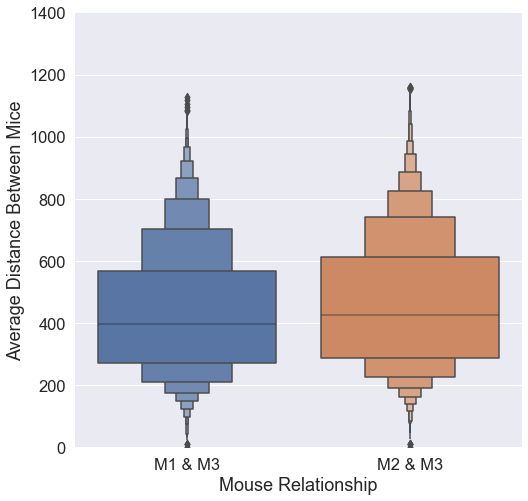

In [39]:
#Show the distributions of total average distancee between the different mice from the M3 prespective
plt.figure(figsize=(8,8))
ax = sns.set(font_scale=1.5)
ax = sns.boxenplot(x=epoch3_melt_df['Relationship'].loc[45257:], #palette="dark", 
                   y='Average Distance',
                 data=epoch3_melt_df, #order = ['0Gy','0Gy & RnaseA+H','2Gy','2Gy & RnaseA+H']
)

ax.set(ylim=(0, 1400),xlabel= "Mouse Relationship", ylabel="Average Distance Between Mice")
sns.despine(left=True, bottom=True)


#plt.savefig(f'dlc_example_boxenplot.png', dpi=900, bbox_inches='tight')

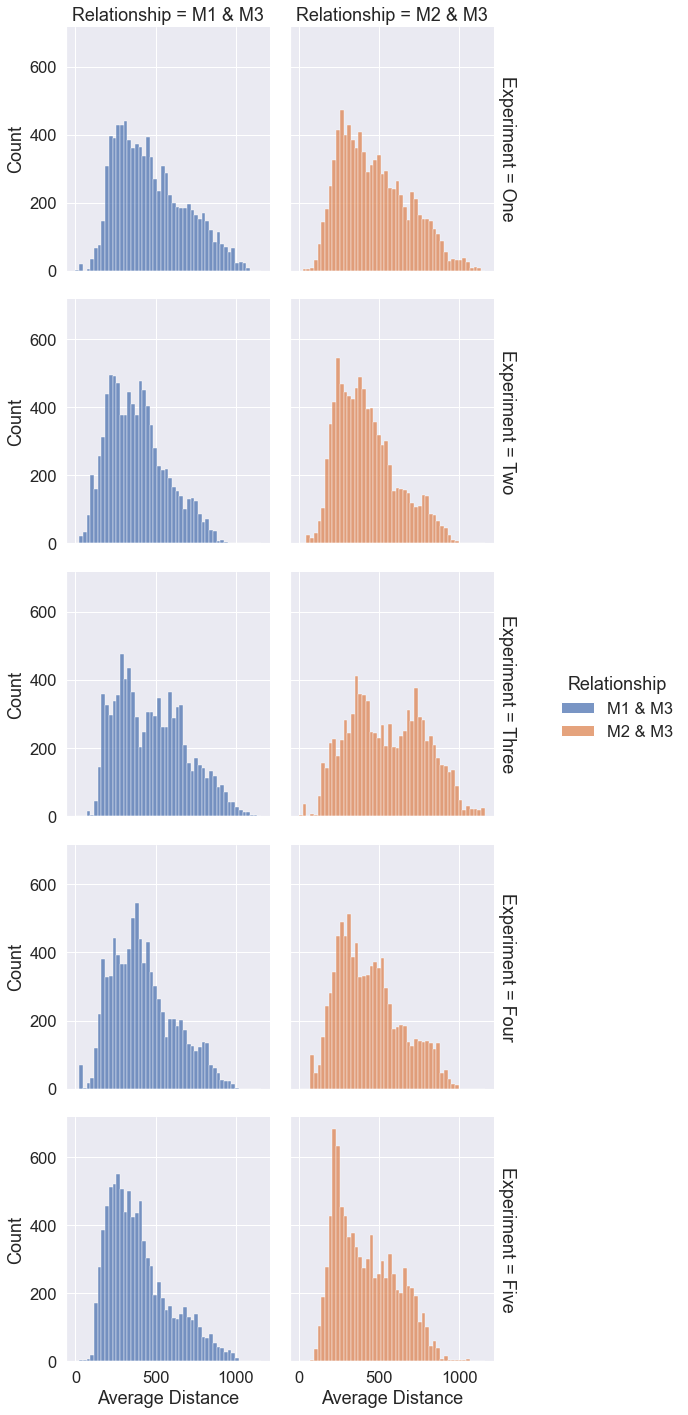

In [40]:
#For each pair in each experiment, 5sec bins (appx. 5mins x 30fps)
sns.displot(
    epoch3_melt_df.loc[45257:], x="Average Distance", col="Relationship", row="Experiment",
    bins=50, hue="Relationship", #palette="husl",
    height=4, facet_kws=dict(margin_titles=True),
)
#plt.savefig(f'dlc_example_facet_hist.png', dpi=900, bbox_inches='tight')

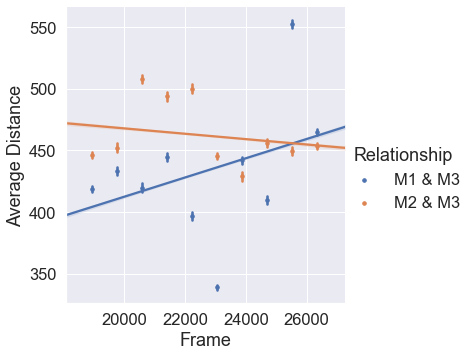

In [41]:
#Plotting only the M3 related data - how the distane of the M3's interactions change over the course of the video
sns.lmplot(x='Frame', y="Average Distance",data=epoch3_melt_df.loc[45257:], hue="Relationship",
           markers='.',x_bins=10, ci=68,
           height=5
)
#plt.savefig(f'dlc_example_lmplot_total.png', dpi=900, bbox_inches='tight')

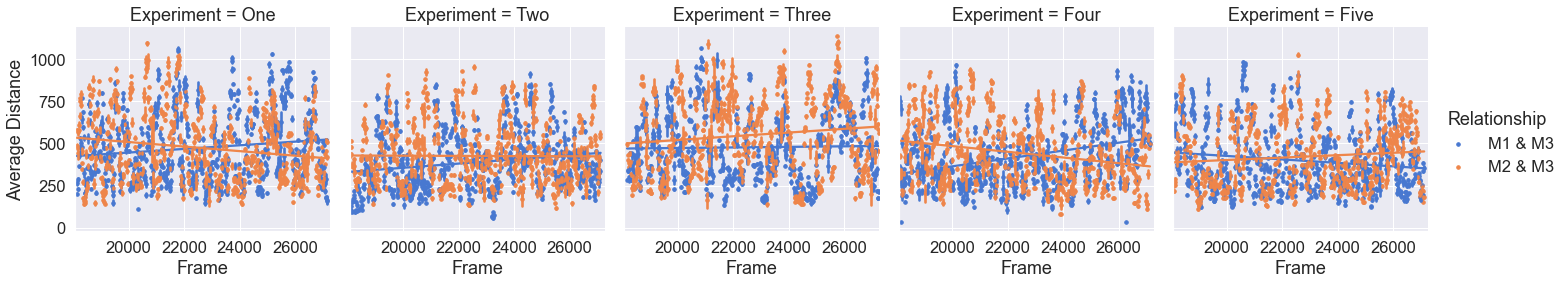

In [54]:
#appx. 5 sec bins
sns.lmplot(x="Frame", y="Average Distance", col="Experiment", hue="Relationship", data=epoch3_melt_df.loc[45257:],
           col_wrap=5, palette="muted", markers='.', height=4, 
           x_bins=600, ci=68,
           #scatter_kws={"s": 50, "alpha": 1}
          )
#plt.savefig(f'dlc_example_facet_lmplot_5sec.png', dpi=900, bbox_inches='tight')

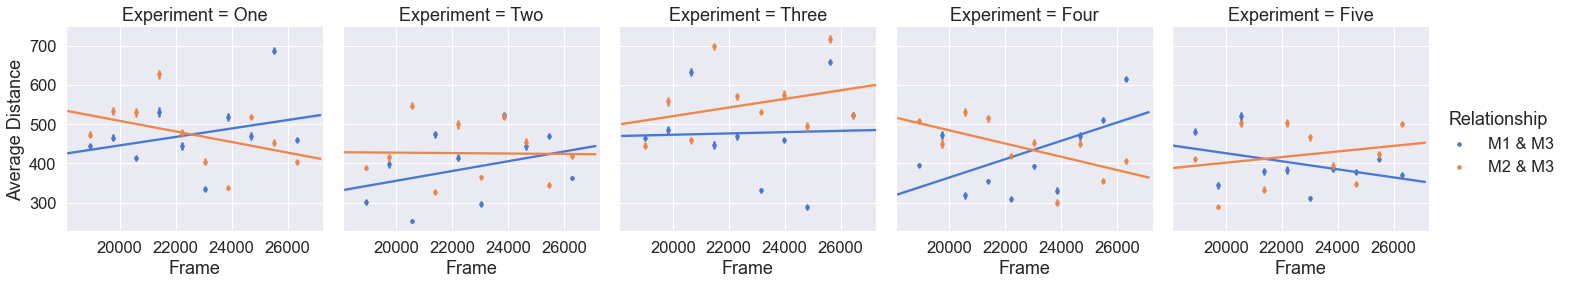

In [52]:
#appx. 30 sec bins
sns.lmplot(x="Frame", y="Average Distance", col="Experiment", hue="Relationship", data=epoch3_melt_df.loc[45257:],
           col_wrap=5, palette="muted", markers='.', height=4, 
           x_bins=10, ci=68,
           #scatter_kws={"s": 50, "alpha": 1}
          )

#plt.savefig(f'dlc_example_facet_lmplot_30sec.png', dpi=900, bbox_inches='tight')

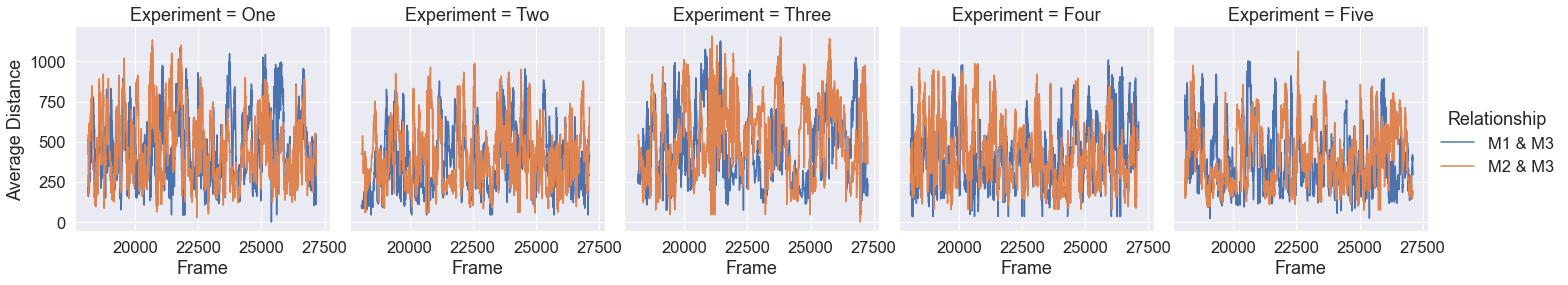

In [53]:
sns.relplot(
    data=epoch3_melt_df.loc[45257:],
    x="Frame", y="Average Distance", col="Experiment", hue="Relationship",ci=68,
    kind="line", height=4
)
#plt.savefig(f'dlc_example_lineplot_nobin.png', dpi=900, bbox_inches='tight')

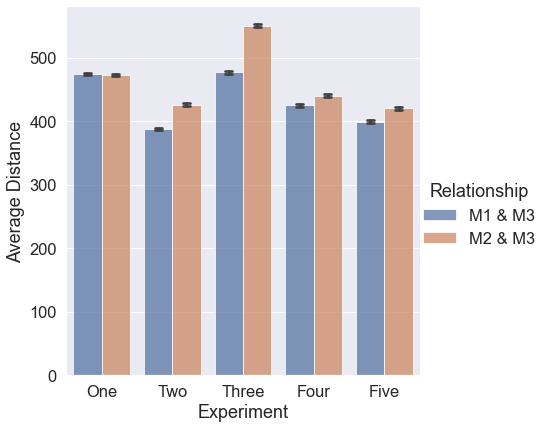

In [45]:
g = sns.catplot(
    data=epoch3_melt_df.loc[45257:], kind="bar",
    x="Experiment", y="Average Distance", #col="Experiment", 
    hue="Relationship",
    ci=68, capsize=0.1,
    alpha=.75, height=6
)
#plt.savefig(f'dlc_example_catplot_exp.png', dpi=900, bbox_inches='tight')

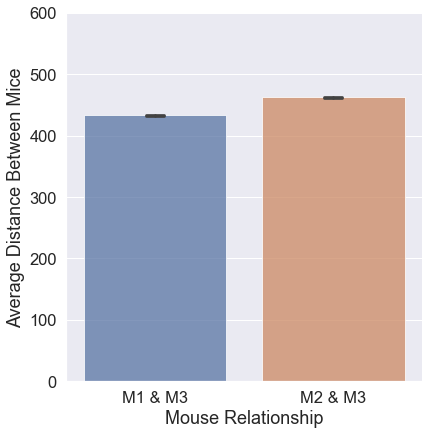

In [49]:
g = sns.catplot(
    data=epoch3_melt_df.loc[45257:], kind="bar",
    x="Relationship", y="Average Distance", #col="Experiment", 
    #hue="Relationship",
    ci=68, capsize=0.1,
    alpha=.75, height=6
)

g.set(ylim=(0, 600),xlabel= "Mouse Relationship", ylabel="Average Distance Between Mice")

#plt.savefig(f'dlc_example_catplot_all.png', dpi=900, bbox_inches='tight')

## PDF and CDF



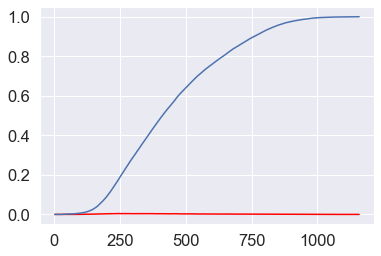

In [31]:
# getting data of the histogram
count, bins_count = np.histogram(epoch3_melt_df['Average Distance'].loc[45257:], bins=600)
  
# finding the PDF of the histogram using count values
pdf = count / sum(count)
  
# using numpy np.cumsum to calculate the CDF
# We can also find using the PDF values by looping and adding
cdf = np.cumsum(pdf)
  
# plotting PDF and CDF
plt.plot(bins_count[1:], pdf, color="red", label="PDF")
plt.plot(bins_count[1:], cdf, label="CDF")

## Percent of time & probability of closeness

# Feild of View test

In [32]:
#plot on polar coord 
https://stackoverflow.com/questions/12038674/x-y-direction-to-degree/12038795
    https://stackoverflow.com/questions/15994194/how-to-convert-x-y-coordinates-to-an-angle/15994225#15994225

SyntaxError: invalid syntax (<ipython-input-32-f3aa5366eb81>, line 2)

In [114]:
#cage1_imputed_df.astype('float')
cage1_Hfov_trial=(np.arctan2(cage1_imputed_df['HomeMouse_Snout_y'],cage1_imputed_df['HomeMouse_Snout_x'])/math.pi*180).to_frame('M1')
cage1_Ufov_trial=(np.arctan2(cage1_imputed_df['UnfamiliarMouse_Snout_y'],cage1_imputed_df['UnfamiliarMouse_Snout_x'])/math.pi*180).to_frame('M2')
cage1_Ffov_trial=(np.arctan2(cage1_imputed_df['FamiliarMouse_Snout_y'],cage1_imputed_df['FamiliarMouse_Snout_x'])/math.pi*180).to_frame('M3')

cage1_Hfov_trial=pd.melt(cage1_Hfov_trial, var_name='Mouse Snout', value_name='Angle From Origin')
cage1_Ufov_trial=pd.melt(cage1_Ufov_trial, var_name='Mouse Snout', value_name='Angle From Origin')
cage1_Ffov_trial=pd.melt(cage1_Ffov_trial, var_name='Mouse Snout', value_name='Angle From Origin')

cage1_fov_trial_df=cage1_Hfov_trial.append(['cage1_Ufov_trial','cage1_Ffov_trial'])
cage1_fov_trial_df=cage1_fov_trial_df.drop(columns=['0'])
cage1_fov_trial_df.head()

KeyError: "['0'] not found in axis"

KeyError: '[1] not in index'

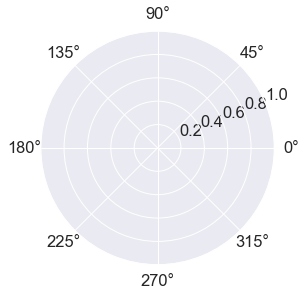

In [118]:
g = sns.FacetGrid(cage1_fov_trial_df, col="Mouse Snout", #hue="Mouse Snout",
                  subplot_kws=dict(projection='polar'), height=4.5,
                  sharex=False, sharey=False, despine=False)
g.map(sns.scatterplot,'Angle From Origin',1
     )